In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
tf.config.experimental_run_functions_eagerly(True)
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D,InputLayer

In [3]:
# Load the data from L1_8000rpm_data/ folder
X_train = pd.read_csv('8000rpm_data_z-score/train_sample.csv')
X_test = pd.read_csv('8000rpm_data_z-score/test_sample.csv')
y_train = pd.read_csv('8000rpm_data_z-score/train_label.csv')
y_test = pd.read_csv('8000rpm_data_z-score/test_label.csv')

## Random Forest

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 转化为y_test_classes
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 初始化随机森林分类器
rf_clf = RandomForestClassifier(
    n_estimators=500,  # 树的数量
    max_depth=None,  # 树的最大深度（None 表示不限制深度）
    min_samples_split=10,  # 内部节点再划分所需最小样本数
    min_samples_leaf=10,  # 叶节点最少样本数
    random_state=42  # 随机种子
)

# 训练模型
rf_clf.fit(X_train, y_train_classes)

# 模型预测
y_pred = rf_clf.predict(X_test)

# 模型评估
print("Accuracy:", accuracy_score(y_test_classes, y_pred))  # 输出总体准确率
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred))


Accuracy: 0.3844444444444444

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.34      0.40        50
           1       0.42      0.44      0.43        50
           2       0.82      0.54      0.65        50
           3       0.42      0.44      0.43        50
           4       0.33      0.26      0.29        50
           5       0.40      0.50      0.44        50
           6       0.25      0.20      0.22        50
           7       0.33      0.40      0.36        50
           8       0.22      0.34      0.27        50

    accuracy                           0.38       450
   macro avg       0.41      0.38      0.39       450
weighted avg       0.41      0.38      0.39       450



In [6]:
#model_best = load_model('best_model.h5')
#y_pred_classes = np.argmax(y_pred, axis=1)
#y_test_classes = np.argmax(y_test, axis=1)
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
conf_mat = confusion_matrix(y_test_classes, y_pred)
# 打印混淆矩阵
print(conf_mat)

[[17 19  6  0  0  0  4  1  3]
 [ 0 22  0  0  0  0  9  9 10]
 [17  2 27  1  1  2  0  0  0]
 [ 0  0  0 22 12 16  0  0  0]
 [ 0  0  0 17 13 20  0  0  0]
 [ 0  0  0 12 13 25  0  0  0]
 [ 0  2  0  0  0  0 10 12 26]
 [ 0  1  0  0  0  0  9 20 20]
 [ 0  6  0  0  0  0  8 19 17]]


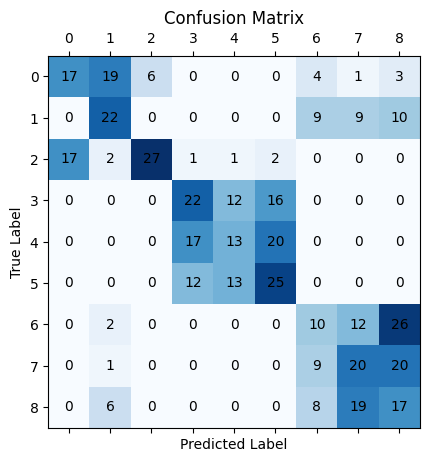

In [7]:
# 绘制混淆矩阵
plt.matshow(conf_mat, cmap='Blues')
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

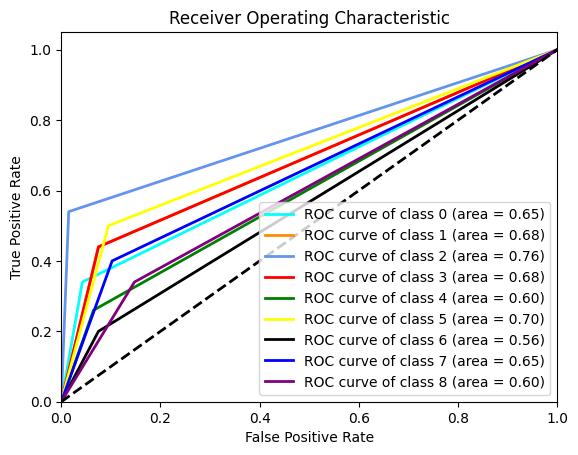

In [8]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib
import matplotlib.pyplot as plt

# 将标签二值化
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure()
lw = 2
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'black', 'blue', 'purple']
for i, color in zip(range(9), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## CNN Model

In [17]:
# 构建 CNN 模型
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(1024, 1)),  # 卷积层
    tf.keras.layers.MaxPooling1D(pool_size=2),  # 最大池化层
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),  # 卷积层
    tf.keras.layers.MaxPooling1D(pool_size=2),  # 最大池化层
    # LSTM 层
    # tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Flatten(),  # 展平层
    tf.keras.layers.Dense(128, activation='relu'),  # 全连接层
    tf.keras.layers.Dropout(0.3),  # Dropout 防止过拟合
    tf.keras.layers.Dense(9, activation='softmax')  # 输出层，9 类 one-hot
])

# 编译模型
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# 模型结构概览
model.summary()


/Users/weiqin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1022, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 511, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 509, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 254, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,080,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,088,393 (7.97 MB)

 Trainable params: 2,088,393 (7.97 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# 训练模型,且记录model.history.history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))
#model.fit(X_train, y_train, epochs=60, batch_size=100, validation_split=0.2, verbose=2)

# 模型预测
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

Epoch 1/50
 5/57 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1053 - loss: 3.3885

/Users/weiqin/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1300 - loss: 2.5824 - val_accuracy: 0.2222 - val_loss: 1.8555
Epoch 2/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3125 - loss: 1.6728

/Users/weiqin/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2635 - loss: 1.7608 - val_accuracy: 0.4133 - val_loss: 1.4354
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3956 - loss: 1.4543 - val_accuracy: 0.4889 - val_loss: 1.2702
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5226 - loss: 1.1978 - val_accuracy: 0.5400 - val_loss: 1.1378
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5927 - loss: 0.9632 - val_accuracy: 0.5400 - val_loss: 1.0045
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7159 - loss: 0.7132 - val_accuracy: 0.5111 - val_loss: 1.0454
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7937 - loss: 0.5478 - val_accuracy: 0.5244 - val_loss: 1.0676
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8121 - loss: 0.4963 - val_accuracy: 0.4778 - val_loss: 1.0883
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8665 - loss: 0.3984 - val_accuracy: 0.5244 - val_loss: 1.

/Users/weiqin/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


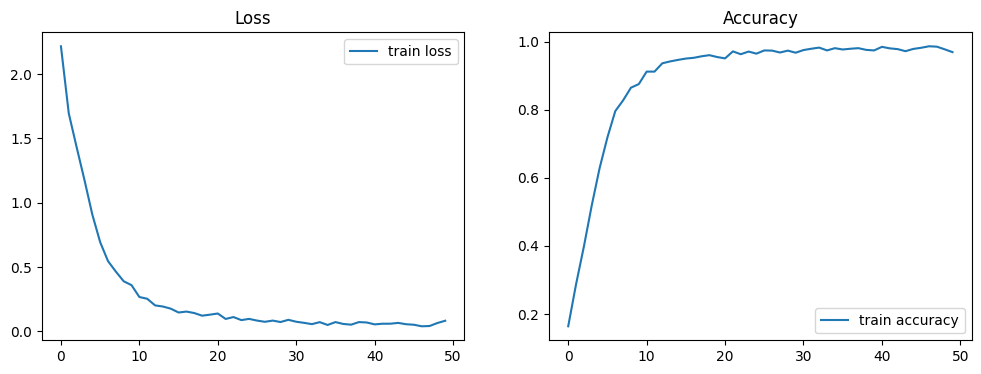

In [19]:
# 可视化训练过程的 loss 和 accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
#plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
#plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

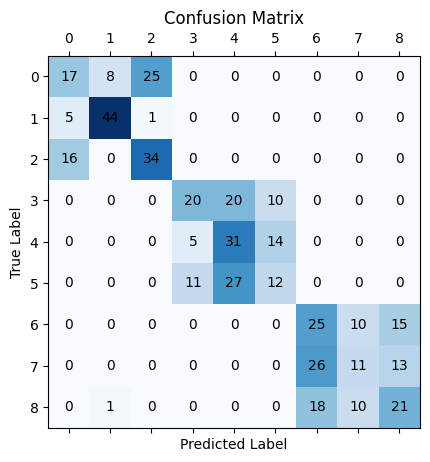

In [20]:
# 计算混淆矩阵
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵
plt.matshow(conf_mat, cmap='Blues')
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
from sklearn.metrics import classification_report

# 评估
print("Classification Report:")
print(classification_report(y_pred=y_pred_classes, y_true=y_test_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.34      0.39        50
           1       0.83      0.88      0.85        50
           2       0.57      0.68      0.62        50
           3       0.56      0.40      0.47        50
           4       0.40      0.62      0.48        50
           5       0.33      0.24      0.28        50
           6       0.36      0.50      0.42        50
           7       0.35      0.22      0.27        50
           8       0.43      0.42      0.42        50

    accuracy                           0.48       450
   macro avg       0.48      0.48      0.47       450
weighted avg       0.48      0.48      0.47       450



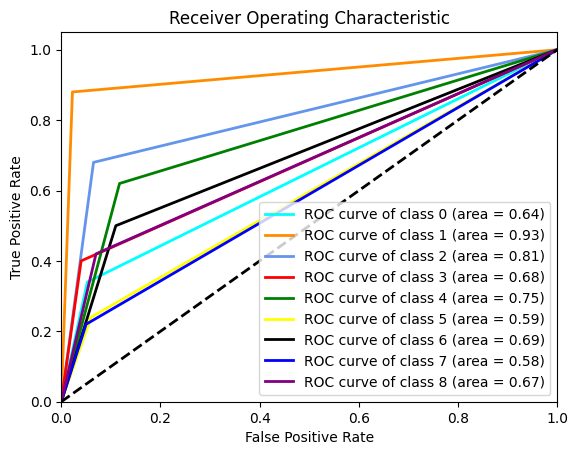

In [22]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib
import matplotlib.pyplot as plt

# 将标签二值化
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
y_pred_bin = label_binarize(y_pred_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure()
lw = 2
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'black', 'blue', 'purple']
for i, color in zip(range(9), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 基于Conv2D的CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape, BatchNormalization
from sklearn.metrics import confusion_matrix

In [24]:
# 构建CNN模型
model = Sequential()
# 为了conv2D，需要将数据reshape成三维
model.add(Reshape((32, 32, 1), input_shape=(1024,)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  # 添加BN层
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
'''model.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())  # 添加BN层
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))'''
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))  # 9个需要预测的类别

model.summary()

/Users/weiqin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,100,169 (8.01 MB)

 Trainable params: 2,100,105 (8.01 MB)

 Non-trainable params: 64 (256.00 B)

In [25]:
# 编译模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
 3/57 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0920 - loss: 8.4483

/Users/weiqin/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/weiqin/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1341 - loss: 7.3209 - val_accuracy: 0.1511 - val_loss: 2.0071
Epoch 2/100
 1/57 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2188 - loss: 1.9945

/Users/weiqin/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2429 - loss: 1.7894 - val_accuracy: 0.3067 - val_loss: 1.8169
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3625 - loss: 1.4377 - val_accuracy: 0.3022 - val_loss: 1.6544
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4354 - loss: 1.2631 - val_accuracy: 0.4756 - val_loss: 1.4237
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5209 - loss: 1.0310 - val_accuracy: 0.3867 - val_loss: 1.3850
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6131 - loss: 0.9064 - val_accuracy: 0.3756 - val_loss: 1.4148
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6840 - loss: 0.7280 - val_accuracy: 0.4400 - val_loss: 1.2747
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6815 - loss: 0.7523 - val_accuracy: 0.4289 - val_loss: 1.2034
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7304 - loss: 0.6316 - val_accuracy: 0.4444 - val_l

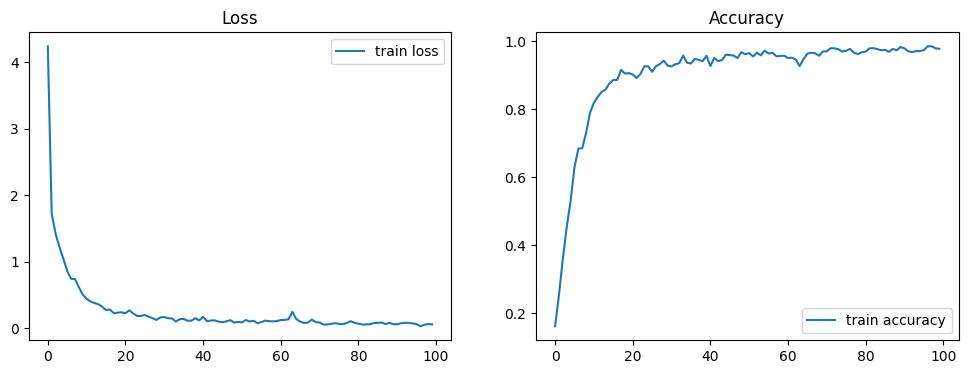

In [26]:
# 可视化训练过程的 loss 和 accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train loss')
#plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='train accuracy')
#plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [28]:
# 模型预测
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/Users/weiqin/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


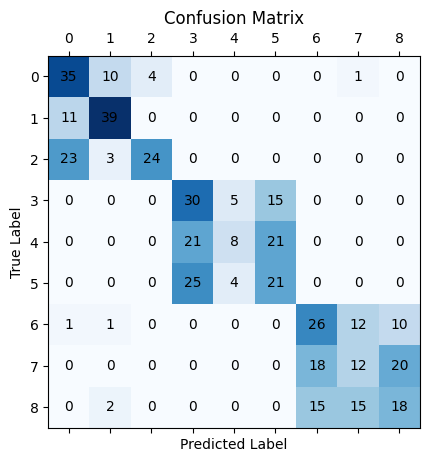

In [29]:
# 计算混淆矩阵
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵
plt.matshow(conf_mat, cmap='Blues')
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [30]:
from sklearn.metrics import classification_report

# 评估
print("Classification Report:")
print(classification_report(y_pred=y_pred_classes, y_true=y_test_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.70      0.58        50
           1       0.71      0.78      0.74        50
           2       0.86      0.48      0.62        50
           3       0.39      0.60      0.48        50
           4       0.47      0.16      0.24        50
           5       0.37      0.42      0.39        50
           6       0.44      0.52      0.48        50
           7       0.30      0.24      0.27        50
           8       0.38      0.36      0.37        50

    accuracy                           0.47       450
   macro avg       0.49      0.47      0.46       450
weighted avg       0.49      0.47      0.46       450



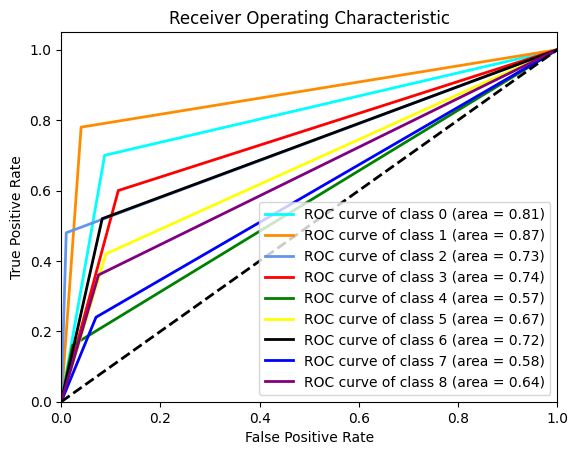

In [ ]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 将标签二值化
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
y_pred_bin = label_binarize(y_pred_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure()
lw = 2
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'black', 'blue', 'purple']
for i, color in zip(range(9), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()